In [2]:
import sys

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from water_batch import WaterBatch
sys.path.append('..')
import dataset
from dataset import B,V,F, FilesIndex, Dataset, Pipeline
from dataset.dataset.models.tf import ResNet50

In [3]:
src = 'data/images/'
di = os.listdir(src)

In [4]:
fileindex = FilesIndex(path='./data/images/*.jpg', no_ext=True)

In [7]:
dset = Dataset(fileindex, batch_class=WaterBatch)
dset.cv_split()

In [8]:
batch = (dset.train.p
        .load(src=src, fmt='jpg', components='images')
        .load(src='./data/labels/meters.csv', \
              fmt='csv',\
              components='labels',\
              usecols=['file_name', 'counter_value'])
        .load(src='./data/labels/answers.csv', \
              fmt='csv', \
              components='coordinates',\
              usecols=['markup']))


In [9]:
%%time
batch = batch.next_batch(10, shuffle=True)

CPU times: user 432 ms, sys: 40 ms, total: 472 ms
Wall time: 187 ms


In [10]:
batch.images.shape

(10, 896, 1600, 3)

In [11]:
batch.labels

['00009.773',
 '00021.218',
 '00013.068',
 '99977.460',
 '99989.288',
 '00022.423',
 '00011.263',
 '99989.865',
 '00002.615',
 '99997.277']

In [12]:
batch.coordinates

array([[569, 182, 519, 140],
       [594, 204, 500, 125],
       [569, 182, 519, 140],
       [456, 204, 583, 127],
       [558, 238, 560, 112],
       [594, 204, 500, 125],
       [569, 182, 519, 140],
       [558, 238, 560, 112],
       [579, 206, 466, 122],
       [495, 238, 487, 101]])

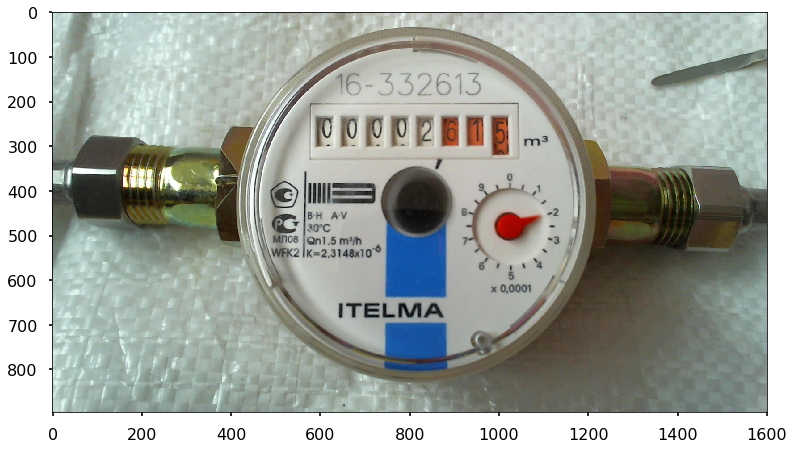

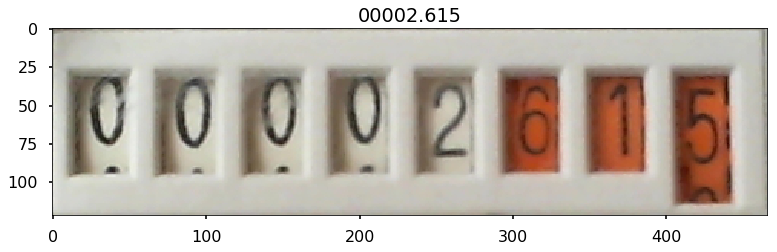

In [18]:
plt.style.use("seaborn-poster")
ind = 8
plt.imshow(batch.images[ind])
plt.show()
x, y, x1, y1 = batch.coordinates[ind]
plt.imshow(batch.images[ind][y:y+y1, x:x+x1])
plt.title(batch.labels[ind])
plt.show()